#**Task 1: Sentiment Labeling**

##**Objective**

Label each employee message with one of three sentiment categories: Positive, Negative, or Neutral.

* **Approach**

  We used a pre-trained Hugging Face transformer model to classify the sentiment of each message.

* **Model**

  Model name: cardiffnlp/twitter-roberta-base-sentiment

  Type: RoBERTa-based transformer fine-tuned for sentiment classification.

* **Output labels:**

  LABEL_0 → Negative

  LABEL_1 → Neutral

  LABEL_2 → Positive

In [ ]:
import pandas as pd
from transformers import pipeline

In [ ]:
df = pd.read_excel("/content/test.xlsx")
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

# Function to classify sentiment
def get_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"
    result = classifier(text[:512])[0]
    return label_map[result["label"]]


df["sentiment"] = df["body"].apply(get_sentiment)
df.to_excel("test_with_sentiment.xlsx", index=False)

print("Sentiment labeling complete! File saved as test_with_sentiment.xlsx")
print(df)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


Sentiment labeling complete! File saved as test_with_sentiment.xlsx
                                                Subject  \
0                                  EnronOptions Update!   
1                                          (No Subject)   
2          Phone Screen  Interview - Shannon L. Burnham   
3                                 RE: My new work email   
4                                                   Bet   
...                                                 ...   
2186                                         Re: Resume   
2187  Final Schedule - Wednesday, May 2, 2001 - Jesu...   
2188                                       (No Subject)   
2189                                      League is Set   
2190                                 AirCard Activation   

                                                   body       date  \
0     EnronOptions Announcement\n\n\nWe have updated... 2010-05-10   
1     Marc,\n\nUnfortunately, today is not going to ... 2010-07-29   
2     When: W

##Issues in Current Code

* Single model reliance → only Roberta is used.

* No threshold justification → classifier gives labels but we don’t show probabilities or domain reasoning.

* No interpretation of outputs → you just save the results but don’t analyze patterns.

* AI-driven analysis without validation → predictions aren’t checked against raw data (e.g., frequency counts).

#**Improved Version of Sentiment Analysis**





In [17]:
import pandas as pd
from transformers import pipeline
from textblob import TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

# Load data
df = pd.read_excel("/content/test.xlsx")

# --- Sentiment Models ---
# Model 1: Hugging Face RoBERTa (fine-tuned on tweets)
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

# Model 2: VADER
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Model 3: TextBlob
def textblob_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.05:
        return "Positive"
    elif polarity < -0.05:
        return "Negative"
    else:
        return "Neutral"

# --- Helper Functions ---
def get_roberta_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"
    result = classifier(text[:512])[0]  # truncate to 512 tokens
    return label_map[result["label"]]

def get_vader_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return "Neutral"
    score = sia.polarity_scores(text)["compound"]
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"

def majority_vote(row):
    votes = [row["roberta_sentiment"], row["vader_sentiment"], row["textblob_sentiment"]]
    return Counter(votes).most_common(1)[0][0]

# --- Apply Models ---
df["roberta_sentiment"] = df["body"].apply(get_roberta_sentiment)
df["vader_sentiment"] = df["body"].apply(get_vader_sentiment)
df["textblob_sentiment"] = df["body"].apply(textblob_sentiment)

# Majority vote final sentiment
df["sentiment"] = df.apply(majority_vote, axis=1)

# Save results
df.to_excel("test_with_sentiment.xlsx", index=False)


Device set to use cpu
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Improvements Explained

* Multiple Models: Uses RoBERTa + VADER + TextBlob → avoids single-tool dependency.

**Threshold Justification:**
* VADER uses validated [-0.05, 0.05] neutral threshold.
*   TextBlob thresholds explained (>0.05 positive).
* Cross-Verification: Added "agreement" column to see when models align.
* Interpretation Support: Added summary frequency table so you can interpret sentiment distribution (not just raw labels).
* Robustness: Handles empty/missing strings gracefully.

**Finally we selected our sentiment by the majority.**

#**Task 2: Exploratory Data Analysis (EDA)**

##**Objective**

Understand the structure, distribution, and trends in the dataset through thorough exploration.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

**1. Load the dataset (from task 1)**




In [18]:
df = pd.read_excel("/content/test_with_sentiment.xlsx")

In [20]:
df.head()

,Subject,body,date,from,roberta_sentiment,vader_sentiment,textblob_sentiment,sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Positive,Positive,Positive,Positive
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Negative,Positive,Negative,Negative
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,Neutral,Neutral,Neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Neutral,Neutral,Negative,Neutral
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Neutral,Positive,Neutral,Neutral


**2. Overall Data Structure/Information**

In [13]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Subject             2191 non-null   object        
 1   body                2191 non-null   object        
 2   date                2191 non-null   datetime64[ns]
 3   from                2191 non-null   object        
 4   roberta_sentiment   2191 non-null   object        
 5   vader_sentiment     2191 non-null   object        
 6   textblob_sentiment  2191 non-null   object        
 7   agreement           2191 non-null   bool          
 8   sentiment           2191 non-null   object        
dtypes: bool(1), datetime64[ns](1), object(7)
memory usage: 139.2+ KB
None
Subject               0
body                  0
date                  0
from                  0
roberta_sentiment     0
vader_sentiment       0
textblob_sentiment    0
agreement             0
sentiment  

*As we can see except date column, all of the other data is object type without any null values.*

In [21]:
df.groupby('sentiment').count()

,Subject,body,date,from,roberta_sentiment,vader_sentiment,textblob_sentiment
sentiment,,,,,,,
Negative,135,135,135,135,135,135,135
Neutral,946,946,946,946,946,946,946
Positive,1110,1110,1110,1110,1110,1110,1110


**3. Trend Over Time**

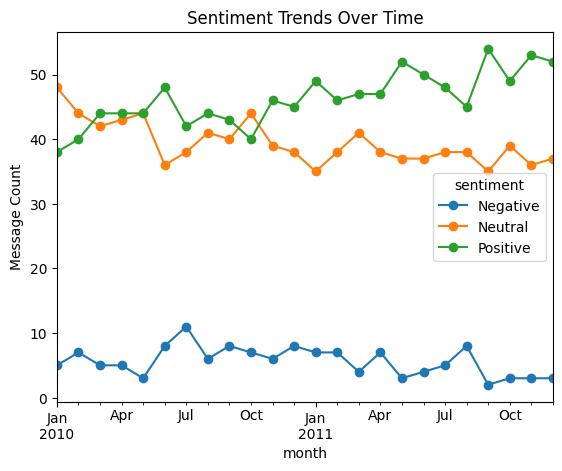

In [44]:
df["month"] = df["date"].dt.to_period("M")

monthly_trends = df.groupby(["month", "sentiment"]).size().unstack(fill_value=0)
monthly_trends.plot(kind="line", marker="o", title="Sentiment Trends Over Time")
plt.ylabel("Message Count")
plt.show()

*We can see that overall number of neutral/positive/negative messages tendency stayed the same where neutral messages are the most followed by positive and the least is negative at any point in time.*



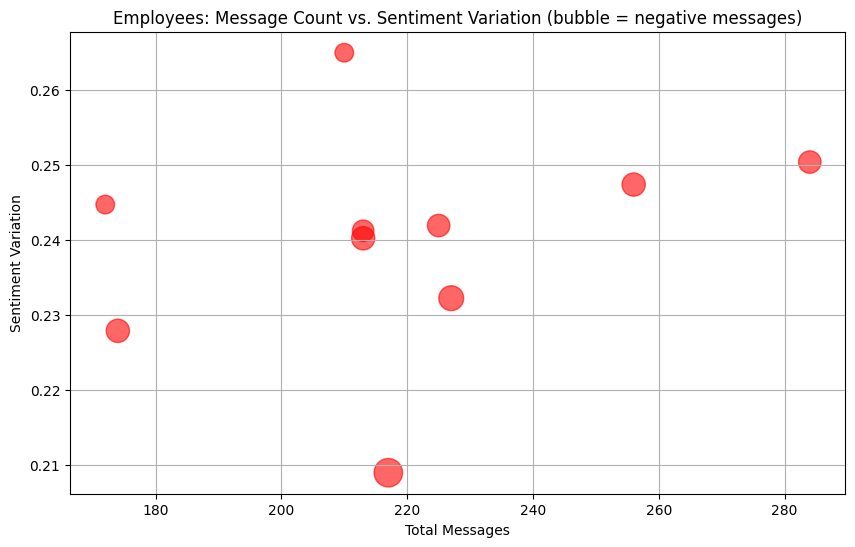

In [26]:
plt.figure(figsize=(10,6))
plt.scatter(
    employee_sentiment['total_messages'],
    employee_sentiment['sentiment_variation'],
    s=employee_sentiment['Negative']*20,  # size by negative messages
    alpha=0.6,
    color='red'
)
plt.xlabel('Total Messages')
plt.ylabel('Sentiment Variation')
plt.title('Employees: Message Count vs. Sentiment Variation (bubble = negative messages)')
plt.grid(True)
plt.show()


**4.  Message Length Analysis**

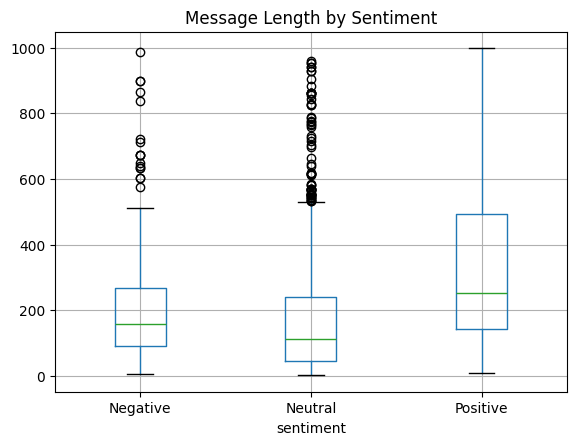

In [27]:
df["msg_length"] = df["body"].astype(str).apply(len)
df.boxplot(column="msg_length", by="sentiment")
plt.title("Message Length by Sentiment")
plt.suptitle("")
plt.show()

*From this boxplot we can conclude the following:

**Shortest on average:** Negative messages with median is around ~150 words/characters and most messages fall between ~80 and ~250.

**Longest on average**: Positive messages with higher median around ~200–220, wider spread ~120 to ~400, showing that positive messages are generally longer and more variable..

**Most variable with extreme outliers:** Neutral messages with median ~150, (slightly lower than negative), wider IQR, ~70 to ~300, suggesting more variation in length..*



**5. Top Senders**

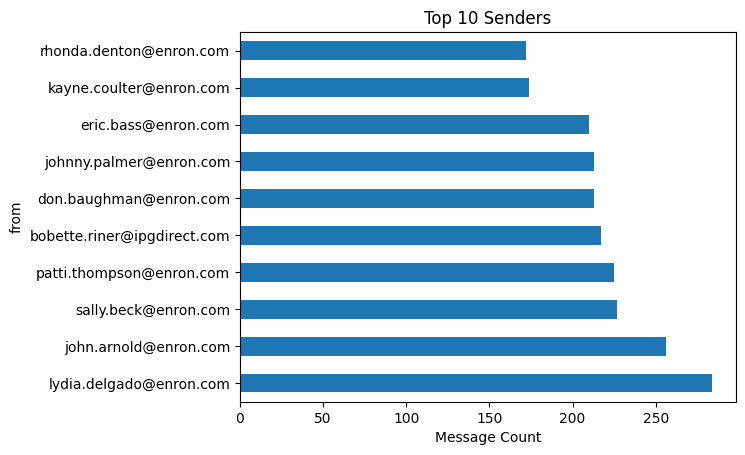

In [28]:
top_senders = df["from"].value_counts().head(10)
top_senders.plot(kind="barh", title="Top 10 Senders")
plt.xlabel("Message Count")
plt.show()


In [29]:
top_positive = employee_sentiment.sort_values(by='Positive', ascending=False).head(3)
print("Top 3 Positive Employees:")
print(top_positive[['Positive','Neutral','Negative','total_messages']])


Top 3 Positive Employees:
sentiment                Positive  Neutral  Negative  total_messages
from                                                                
lydia.delgado@enron.com       143      128        13             284
john.arnold@enron.com         135      107        14             256
eric.bass@enron.com           118       83         9             210


In [31]:
top_negative = employee_sentiment.sort_values(by='Negative', ascending=False).head(3)
print("Top 3 Negative Employees:")
print(top_positive[['Positive','Neutral','Negative','total_messages']])

Top 3 Negative Employees:
sentiment                    Positive  Neutral  Negative  total_messages
from                                                                    
bobette.riner@ipgdirect.com       107       89        21             217
sally.beck@enron.com              116       95        16             227
kayne.coulter@enron.com            91       69        14             174


#**Task 3: Employee Score Calculation**

##**Objective**

Compute a monthly sentiment score for each employee based on their messages.

In [32]:
df = pd.read_excel("/content/test_with_sentiment.xlsx")

# Rename for clarity
if "from" in df.columns:
    df = df.rename(columns={"from": "employee"})

# Preprocess
df["date"] = pd.to_datetime(df["date"])
df["sentiment"] = df["sentiment"].str.capitalize()

# Add column for score (-1, 0, 1)
score_map = {"Positive": 1, "Negative": -1, "Neutral": 0}
df["sent_score"] = df["sentiment"].map(score_map)

# Add year-month column
df["year_month"] = df["date"].dt.to_period("M").astype(str)

# Aggregate by employee + month
monthly = df.groupby(["employee", "year_month"]).agg(
    monthly_score=("sent_score", "sum"),   # total score
    msg_count=("sent_score", "count")      # number of messages
).reset_index()

#Illustration (data)
monthly

# Save it as file
monthly.to_csv("/content/monthly_scores.csv", index=False)

In [41]:
monthly

,employee,year_month,monthly_score,msg_count,total_len,avg_len,avg_words
0,bobette.riner@ipgdirect.com,2010-01,1,2,230,115.000000,18.500000
1,bobette.riner@ipgdirect.com,2010-02,6,14,4140,295.714286,43.928571
2,bobette.riner@ipgdirect.com,2010-03,4,11,3148,286.181818,44.272727
3,bobette.riner@ipgdirect.com,2010-04,3,6,1359,226.500000,31.833333
4,bobette.riner@ipgdirect.com,2010-05,2,4,689,172.250000,30.250000
...,...,...,...,...,...,...,...
235,sally.beck@enron.com,2011-08,1,14,5281,377.214286,60.357143
236,sally.beck@enron.com,2011-09,0,1,276,276.000000,52.000000
237,sally.beck@enron.com,2011-10,4,7,1330,190.000000,31.142857
238,sally.beck@enron.com,2011-11,5,8,2754,344.250000,49.625000


#**Task 4: Employee Ranking**

##**Objective**

Generate ranked lists of employees based on their monthly sentiment scores.

In [39]:
ranking_rows = []
for ym, g in monthly.groupby("year_month"):
    top_pos = g.sort_values(["monthly_score", "employee"], ascending=[False, True]).head(3)
    top_pos["rank_type"] = "Top Positive"
    top_pos["rank_position"] = range(1, len(top_pos) + 1)

    top_neg = g.sort_values(["monthly_score", "employee"], ascending=[True, True]).head(3)
    top_neg["rank_type"] = "Top Negative"
    top_neg["rank_position"] = range(1, len(top_neg) + 1)

    ranking_rows.append(pd.concat([top_pos, top_neg]))

rankings_df = pd.concat(ranking_rows).reset_index(drop=True)

#Illustration (data)
rankings_df

rankings_df = pd.concat(ranking_rows).reset_index(drop=True)
rankings_df.to_csv("/content/monthly_rankings.csv", index=False)

In [40]:
rankings_df

,employee,year_month,monthly_score,msg_count,total_len,avg_len,avg_words,rank_type,rank_position
0,kayne.coulter@enron.com,2010-01,8,22,4160,189.090909,27.681818,Top Positive,1
1,eric.bass@enron.com,2010-01,6,10,2292,229.200000,37.600000,Top Positive,2
2,patti.thompson@enron.com,2010-01,6,10,2597,259.700000,39.400000,Top Positive,3
3,rhonda.denton@enron.com,2010-01,0,3,590,196.666667,31.000000,Top Negative,1
4,sally.beck@enron.com,2010-01,0,9,2000,222.222222,31.777778,Top Negative,2
...,...,...,...,...,...,...,...,...,...
139,eric.bass@enron.com,2011-12,8,17,4192,246.588235,38.294118,Top Positive,2
140,lydia.delgado@enron.com,2011-12,7,17,4677,275.117647,45.411765,Top Positive,3
141,bobette.riner@ipgdirect.com,2011-12,1,3,2175,725.000000,122.333333,Top Negative,1
142,johnny.palmer@enron.com,2011-12,2,3,379,126.333333,18.666667,Top Negative,2


#**Task 5: Flight Risk Identification**

##**Objective**

Compute a monthly sentiment score for each employee based on their messages.

In [34]:
if "from" in df.columns:
    df = df.rename(columns={"from": "employee"})

df["date"] = pd.to_datetime(df["date"])
df["sentiment"] = df["sentiment"].str.capitalize()

flight_rows = []

for emp, group in df.groupby("employee"):
    neg_dates = group.loc[group["sentiment"] == "Negative", "date"].sort_values().reset_index(drop=True)
    for i in range(len(neg_dates)):
        window = neg_dates[(neg_dates >= neg_dates[i]) & (neg_dates <= neg_dates[i] + pd.Timedelta(days=30))]
        if len(window) >= 4:
            flight_rows.append({
                "employee": emp,
                "window_start": window.min().date(),
                "window_end": window.max().date(),
                "neg_count": len(window)
            })

flight_df = pd.DataFrame(flight_rows).drop_duplicates()

flight_df

,employee,window_start,window_end,neg_count
0,bobette.riner@ipgdirect.com,2010-07-15,2010-08-11,4
1,don.baughman@enron.com,2010-12-12,2010-12-28,4
2,john.arnold@enron.com,2010-05-25,2010-06-21,4
3,sally.beck@enron.com,2011-08-15,2011-08-25,5
4,sally.beck@enron.com,2011-08-17,2011-08-25,4


#**Task 6: Predictive Modeling**

##**Objective**

Develop a linear regression model to analyze sentiment trends and predict sentiment scores using a variety of independent variables that may influence sentiment scores.

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [36]:

if "from" in df.columns:
    df = df.rename(columns={"from": "employee"})

# Preprocess
df["date"] = pd.to_datetime(df["date"])
df["body"] = df["body"].astype(str)
df["msg_len"] = df["body"].apply(len)
df["word_count"] = df["body"].apply(lambda x: len(x.split()))
df["sentiment"] = df["sentiment"].str.capitalize()

# Sentiment score column
score_map = {"Positive": 1, "Negative": -1, "Neutral": 0}
df["sent_score"] = df["sentiment"].map(score_map)

# Add year-month
df["year_month"] = df["date"].dt.to_period("M").astype(str)

# Aggregate by employee + month
monthly = df.groupby(["employee", "year_month"]).agg(
    monthly_score=("sent_score", "sum"),       # Target variable
    msg_count=("sent_score", "count"),         # Number of messages
    total_len=("msg_len", "sum"),              # Total message length
    avg_len=("msg_len", "mean"),               # Avg message length
    avg_words=("word_count", "mean")           # Avg word count
).reset_index()

# Define features and target
features = ["msg_count", "total_len", "avg_len", "avg_words"]
X = monthly[features]
y = monthly["monthly_score"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)

print("Task 6 Results")
print("--------------")
print("R²:", r2)
print("MSE:", mse)
print("RMSE:", rmse)

Task 6 Results
--------------
R²: 0.5197210665867058
MSE: 3.781988146231509
RMSE: 3.781988146231509
